In [60]:
%matplotlib inline
import numpy as np

import torch

import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchvision.transforms as transforms
from torch.utils.data import  Dataset, TensorDataset, DataLoader


import lib.pytorch_trainer as ptt

from src.imgnet_utils import denormalize

from src.data_loader import _create_dataLoader

from src.Dataset import KaggleSafeDriverDataset

from src.plot_utils import (plot_classes, plot_distribution,
                            statistical_analysis_image, classDistribution,
                            plot_metrics,visualize_predictions,
                            plot_cm_train_valid,plot_layers_weight)
                           
from src.features_extractor import (MyResNet, MyInception, MyDenseNet,
                                    predict, getPrediction)

from utils.make_submission import *

In [61]:
print("{} GPU's available:".format(torch.cuda.device_count()) )
cpu_count = torch.multiprocessing.cpu_count()
print("\ncpu_count: {}".format(cpu_count))

4 GPU's available:

cpu_count: 24


In [62]:
use_gpu= True
use_DataParalel= False # Need some improvement on model's to work properly, basically it has to wrap all models block:
use_CPU= False         # http://pytorch.org/tutorials/beginner/former_torchies/parallelism_tutorial.html 

if use_CPU: 
    print("Using multiprocessing in {} CPU's".format(cpu_count))

elif use_gpu: 
    
#    device_id = 2  # Chose the GPU to be used. 
#    torch.cuda.device(device_id)
    print('Using only one GPU') #{} '.format(device_id))

elif use_DataParalel:
    print("Using DataParalel in all {} GPUS".format(torch.cuda.device_count()))

Using only one GPU


In [63]:
if use_gpu:
    !free -h
    !nvidia-smi

              total        used        free      shared  buff/cache   available
Mem:           220G         77G        130G        602M         12G        140G
Swap:            0B          0B          0B
Mon Nov 20 18:48:56 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.90                 Driver Version: 384.90                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00003609:00:00.0 Off |                    0 |
| N/A   42C    P0    72W / 149W |   7070MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 00004BDC:0


# Choose dataset 

In [64]:
path2train = "/mnt/home/e209440/data/train" 
path2test = "/mnt/home/e209440/data/test" 

# Images transformation

In [92]:
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std  = np.array([0.229, 0.224, 0.225])

img_width = img_height=300 #to use InceptionV3 it must img_width and img_height be changed to 300

# Data augmentation and normalization for training 
data_transforms = {
    'train': transforms.Compose([
#        transforms.RandomHorizontalFlip(), First try withouth Data Augmentation 
        transforms.Scale((img_width, img_height)),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]),
    'valid': transforms.Compose([
        transforms.Scale((img_width, img_height)),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]),
}

# Creating  Dataset & Dataloader

In [93]:
batch_size = 180
use_only = 1.0 # Use only is the percentage of the full dataset

In [94]:
dsets = {
    'train': KaggleSafeDriverDataset(path2train, transforms=data_transforms['train'],use_only=use_only),
    'valid': KaggleSafeDriverDataset(path2train, transforms=data_transforms['valid'],use_only=use_only, is_val=True, val_size=0.2),
    'test':  KaggleSafeDriverDataset(path2test, transforms=data_transforms['valid'],use_only=use_only, is_test=True),
}

In [95]:
dset_loaders = _create_dataLoader(dsets, batch_size, 
                                  num_workers=cpu_count, use_DataParalel=use_DataParalel,
                                  use_gpu=use_gpu)


In [96]:
dset_sizes = {x: len(dsets[x]) for x in ['train','valid', 'test']} 
dset_classes = len(dsets['train'].y)
dset_classes, dset_sizes

# Dataset have much more samples than datatrain ***It comes from the test.zip****

(17940, {'test': 79726, 'train': 17940, 'valid': 4484})

# Plotting some examples

torch.Size([3, 300, 300]) torch.Size([180])


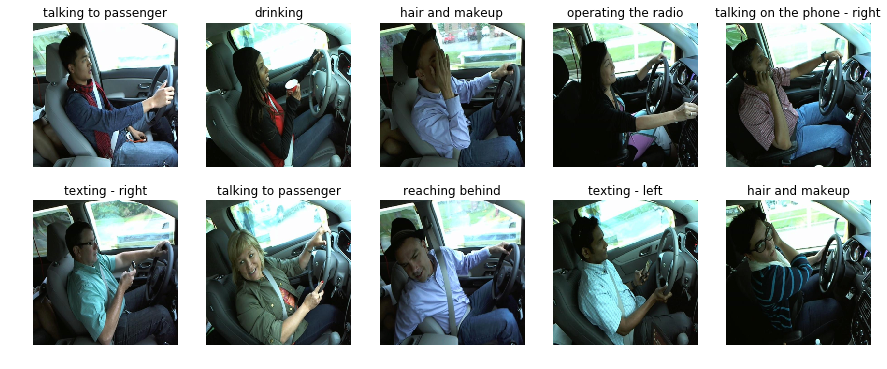

In [97]:
plot_classes(dset_loaders['train'])

# Data Analysis

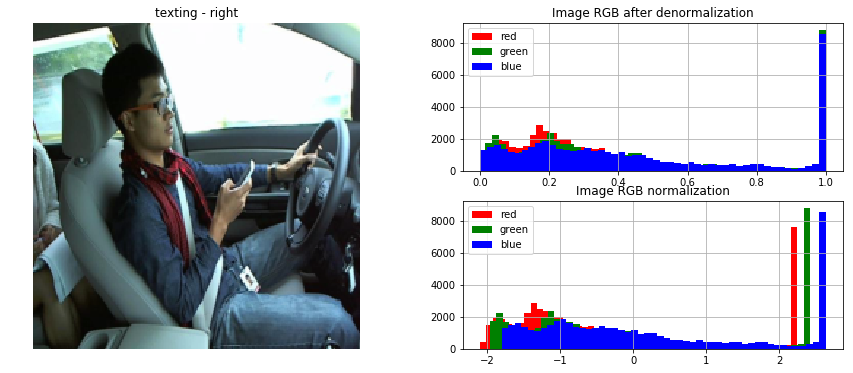

In [71]:
statistical_analysis_image(dset_loaders['train'])

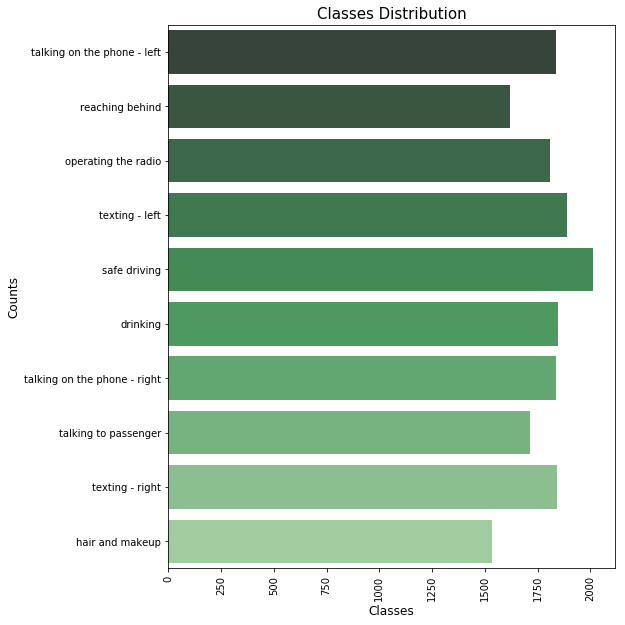

In [72]:
classDistribution(dsets['train'])

# Checking GPU usage

In [73]:
if use_gpu:
    !free -h
    !nvidia-smi

              total        used        free      shared  buff/cache   available
Mem:           220G         77G        129G        912M         13G        140G
Swap:            0B          0B          0B
Mon Nov 20 18:49:08 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.90                 Driver Version: 384.90                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00003609:00:00.0 Off |                    0 |
| N/A   42C    P0    72W / 149W |   7070MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 00004BDC:0

# Choosing Model

In [98]:
use_resnet = True
use_inception = False
use_denseNet = False

if use_resnet:
    print('Using ResNet model')
    model = MyResNet()
elif use_inception:
    print('Using Inception model')
    model = MyInception()
elif use_denseNet:
    print('Using DenseNet model')    
    model = MyDenseNet()

Using ResNet model


In [99]:
if use_gpu:
    print('Using GPU')# {}'.format(device_id))
    model.cuda()
    convnet = model.mrnc
    densenet = model.mrnd
    
elif use_DataParalel:
    print("Using all GPU's ")
    model = torch.nn.DataParallel(model)
    #    model.cuda()
    convnet = model.module.mrnc
    densenet = model.module.mrnd
else:
    convnet = model.mrnc
    densenet = model.mrnd

Using GPU


In [91]:
#print(model)

In [100]:
convOutput_train = predict(dset_loaders['train'], convnet,use_gpu=use_gpu)
convOutput_valid = predict(dset_loaders['valid'], convnet,use_gpu=use_gpu)

predict: 99/99 ok
predict: 24/24 ok


In [101]:
print(convOutput_train['true'].size(), convOutput_train['pred'].size())
print(convOutput_valid['true'].size(), convOutput_valid['pred'].size())

torch.Size([17940]) torch.Size([17940, 6400])
torch.Size([4484]) torch.Size([4484, 6400])


In [102]:
print(convOutput_train['true'].type(), convOutput_train['pred'].type())

torch.cuda.LongTensor torch.cuda.FloatTensor


In [103]:
conv_dset ={
    'train': TensorDataset(convOutput_train['pred'], convOutput_train['true']),
    'valid': TensorDataset(convOutput_valid['pred'], convOutput_valid['true'])
} 

In [104]:
dset_loaders_convnet = _create_dataLoader(conv_dset, batch_size, 
                                  num_workers=cpu_count, use_DataParalel=True,
                                  use_gpu=False,shuffle= False)

In [105]:
dset_convnet_sizes = {x: len(dset_loaders_convnet[x]) for x in ['train','valid']} 
dset_convnet_sizes

{'train': 100, 'valid': 25}

In [106]:
path2saveModel = '/mnt/home/r120084/project/models/distractdriver'
#path2saveModel = '/mnt/home/e209440/models/ResNetDistractDriver' 

savebest = ptt.ModelCheckpoint(path2saveModel,reset=True, verbose=1)

In [107]:
loss_fn = nn.CrossEntropyLoss()
num_epochs = 100

optimizer =  optim.Adam(densenet.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=5, gamma=0.75)

params = {'model' : densenet, 
    'criterion': loss_fn,  
    'optimizer': optimizer, 
    'callbacks': [savebest,  ptt.PrintCallback()] #ptt.PlotCallback(),
}

In [108]:
trainer = ptt.DeepNetTrainer(use_gpu=use_gpu,**params)

In [109]:
trainer.fit_loader(num_epochs, dset_loaders_convnet['train'], dset_loaders_convnet['valid'])

Start training for 100 epochs
  1:   1.5s   T: 2.43746   V: 2.22660 best
  2:   1.1s   T: 1.95609   V: 1.49115 best
  3:   1.0s   T: 0.94411   V: 0.68154 best
  4:   1.0s   T: 0.45884   V: 0.32310 best
  5:   1.0s   T: 0.22558   V: 0.14827 best
  6:   0.9s   T: 0.17427   V: 0.14978 
  7:   0.9s   T: 0.11375   V: 0.08347 best
  8:   0.9s   T: 0.08449   V: 0.07057 best
  9:   0.9s   T: 0.06622   V: 0.05515 best
 10:   0.9s   T: 0.05545   V: 0.06299 
 11:   0.9s   T: 0.30115   V: 0.09017 
 12:   0.9s   T: 0.05745   V: 0.05129 best
 13:   0.9s   T: 0.04518   V: 0.04882 best
 14:   0.9s   T: 0.04246   V: 0.05461 
 15:   0.9s   T: 0.03915   V: 0.04560 best
 16:   0.9s   T: 0.03154   V: 0.03942 best
 17:   0.9s   T: 0.55221   V: 0.36264 
 18:   0.9s   T: 0.12387   V: 0.07520 
 19:   0.9s   T: 0.06326   V: 0.05792 
 20:   0.9s   T: 0.04874   V: 0.05209 
 21:   0.9s   T: 0.04022   V: 0.03654 best
 22:   0.9s   T: 0.03319   V: 0.03427 best
 23:   0.9s   T: 0.03007   V: 0.03549 
 24:   0.9s   T: 

# Loading best epoch

In [110]:
ptt.load_trainer_state(path2saveModel,model.mrnd,trainer.metrics) 

In [111]:
if use_gpu:
    !free -h
    !nvidia-smi

              total        used        free      shared  buff/cache   available
Mem:           220G         77G        129G        891M         13G        140G
Swap:            0B          0B          0B
Mon Nov 20 19:01:30 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.90                 Driver Version: 384.90                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00003609:00:00.0 Off |                    0 |
| N/A   53C    P0    73W / 149W |   8064MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 00004BDC:0

In [112]:
#plot_metrics(trainer)

In [113]:
train_eval = trainer.evaluate_loader(dset_loaders_convnet['train'])
valid_eval = trainer.evaluate_loader(dset_loaders_convnet['valid'])

evaluate: 99/99 ok
evaluate: 24/24 ok


In [114]:
train_eval, valid_eval

({'losses': 0.0008764835644940095}, {'losses': 0.019491687867114194})

In [115]:
dset_loaders_wshuffle = _create_dataLoader(dsets, batch_size, num_workers=cpu_count,
                                           use_gpu=use_gpu,use_DataParalel=use_DataParalel, shuffle=False)

In [116]:
result_train = predict(dset_loaders_wshuffle['train'], model,use_gpu=use_gpu)
result_valid = predict(dset_loaders_wshuffle['valid'], model,use_gpu=use_gpu)
result_test = predict(dset_loaders_wshuffle['test'], model,use_gpu=use_gpu)

predict: 99/99 ok
predict: 24/24 ok
predict: 442/442 ok


In [117]:
result_train = getPrediction(result_train)
result_valid = getPrediction(result_valid)
# result_test['pred'] must be an array of probabilities to make the submission

In [118]:
correct_train = (result_train['true'] == result_train['pred']).sum()
correct_valid = (result_valid['true'] == result_valid['pred']).sum()

In [119]:
print('Train: ', correct_train, '/', len(conv_dset['train']) )
print('Valid: ', correct_valid, '/', len(conv_dset['valid']) )

Train:  17940 / 17940
Valid:  4467 / 4484


In [120]:
#visualize_predictions(dsets['valid'], result_valid, correct_pred = True)

In [121]:
#visualize_predictions(dsets['valid'], result_valid, correct_pred = False)

In [122]:
#plot_cm_train_valid(result_train,result_valid)

In [123]:
#plot_layers_weight(dsets,img_width=img_width, img_height=img_height,conv_model = model.mrnc,use_gpu=use_gpu)

# Make submission of the Test set

In [124]:
create_submission(result_test, 'distracted_driver')

done!
